In [1]:
import pandas as pd
import re
import time
import datetime
import pickle
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegressionCV
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import scorecard_function

D:\a\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def CareerYear(x):
    # 对工作年限进行转换
    x = str(x)
    if x.find('nan') > -1:
        return -1
    elif x.find("10+") > -1:  # 将"10＋years"转换成 11
        return 11
    elif x.find('< 1') > -1:  # 将"< 1 year"转换成 0
        return 0
    else:
        return int(re.sub("\D", "", x))  # 其余数据，去掉"years"并转换成整数


def DescExisting(x):
    # 将desc变量转换成有记录和无记录两种
    if type(x).__name__ == 'float':
        return 'no desc'
    else:
        return 'desc'


def ConvertDateStr(x):
    mth_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10,
                'Nov': 11, 'Dec': 12}
    if str(x) == 'nan':
        return datetime.datetime.fromtimestamp(time.mktime(time.strptime('9900-1', '%Y-%m')))
        # time.mktime 不能读取1970年之前的日期
    else:
        yr = int(x[4:6])
        if yr <= 17:
            yr = 2000 + yr
        else:
            yr = 1900 + yr
        mth = mth_dict[x[:3]]
        return datetime.datetime(yr, mth, 1)


def MonthGap(earlyDate, lateDate):
    if lateDate > earlyDate:
        gap = relativedelta(lateDate, earlyDate)
        yr = gap.years
        mth = gap.months
        return yr * 12 + mth
    else:
        return 0


def MakeupMissing(x):
    if np.isnan(x):
        return -1
    else:
        return x

In [3]:
# 数据预处理
# 1，读入数据
# 2，选择合适的建模样本
# 3，数据集划分成训练集和测试集


folderOfData = './'

allData = pd.read_csv(folderOfData + 'application.csv', header=0, encoding='latin1')
allData['term'] = allData['term'].apply(lambda x: int(x.replace(' months', '')))

# 处理标签：Fully Paid是正常用户；Charged Off是违约用户
allData['y'] = allData['loan_status'].map(lambda x: int(x == 'Charged Off'))

In [4]:
'''
由于存在不同的贷款期限（term），申请评分卡模型评估的违约概率必须要在统一的期限中，且不宜太长，所以选取term＝36months的行本
'''

allData1 = allData.loc[allData.term == 36]

trainData, testData = train_test_split(allData1, test_size=0.4)

# 固化变量
trainDataFile = open(folderOfData + 'trainData.pkl', 'wb+')
pickle.dump(trainData, trainDataFile)
trainDataFile.close()

testDataFile = open(folderOfData + 'testData.pkl', 'wb+')
pickle.dump(testData, testDataFile)
testDataFile.close()


In [5]:
'''
第一步：数据预处理，包括
（1）数据清洗
（2）格式转换
（3）确实值填补
'''

# 将带％的百分比变为浮点数
trainData['int_rate_clean'] = trainData['int_rate'].map(lambda x: float(x.replace('%', '')) / 100)

# 将工作年限进行转化，否则影响排序
trainData['emp_length_clean'] = trainData['emp_length'].map(CareerYear)

# 将desc的缺失作为一种状态，非缺失作为另一种状态
trainData['desc_clean'] = trainData['desc'].map(DescExisting)

# 处理日期。earliest_cr_line的格式不统一，需要统一格式且转换成python的日期
trainData['app_date_clean'] = trainData['issue_d'].map(lambda x: ConvertDateStr(x))
trainData['earliest_cr_line_clean'] = trainData['earliest_cr_line'].map(lambda x: ConvertDateStr(x))

# 处理mths_since_last_delinq。原始值中有0，用－1代替缺失
trainData['mths_since_last_delinq_clean'] = trainData['mths_since_last_delinq'].map(lambda x: MakeupMissing(x))

trainData['mths_since_last_record_clean'] = trainData['mths_since_last_record'].map(lambda x: MakeupMissing(x))

trainData['pub_rec_bankruptcies_clean'] = trainData['pub_rec_bankruptcies'].map(lambda x: MakeupMissing(x))


D:\a\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


ValueError: invalid literal for int() with base 10: ''

In [6]:
'''
第二步：变量衍生
'''
# 考虑申请额度与收入的占比
trainData['limit_income'] = trainData.apply(lambda x: x.loan_amnt / x.annual_inc, axis=1)

# 考虑earliest_cr_line到申请日期的跨度，以月份记
trainData['earliest_cr_to_app'] = trainData.apply(lambda x: MonthGap(x.earliest_cr_line_clean, x.app_date_clean),
                                                  axis=1)


In [7]:
trainData.head()

,member_id,loan_amnt,term,loan_status,int_rate,emp_length,home_ownership,annual_inc,verification_status,desc,...,int_rate_clean,emp_length_clean,desc_clean,app_date_clean,earliest_cr_line_clean,mths_since_last_delinq_clean,mths_since_last_record_clean,pub_rec_bankruptcies_clean,limit_income,earliest_cr_to_app
1515,1516,18000,36,Fully Paid,10.65%,10+ years,RENT,63000.0,Source Verified,Borrower added on 12/02/11 > A Bill Consolid...,...,0.1065,11,desc,2011-12-01,1994-11-01,21.0,-1.0,0.0,0.285714,205
37785,37786,15000,36,Fully Paid,9.63%,2 years,RENT,55000.0,Not Verified,This loan will be used to eliminate my revolvi...,...,0.0963,2,desc,2009-01-01,1995-05-01,-1.0,-1.0,0.0,0.272727,164
32355,32356,8000,36,Fully Paid,13.11%,2 years,RENT,48000.0,Not Verified,Borrower added on 02/10/10 > Thanks for read...,...,0.1311,2,desc,2010-02-01,1999-11-01,30.0,-1.0,0.0,0.166667,123
11199,11200,15000,36,Fully Paid,5.99%,10+ years,MORTGAGE,95200.0,Not Verified,Borrower added on 07/17/11 > looking to pay ...,...,0.0599,11,desc,2011-07-01,1980-11-01,-1.0,-1.0,0.0,0.157563,368
38523,38525,7500,36,Fully Paid,14.75%,1 year,RENT,30000.0,Not Verified,our company provides stores with a unique serv...,...,0.1475,1,desc,2008-08-01,1999-09-01,82.0,-1.0,0.0,0.250000,107


In [8]:
'''
第三步：分箱，采用ChiMerge,要求分箱完之后：
（1）不超过5箱
（2）Bad Rate单调
（3）每箱同时包含好坏样本
（4）特殊值如－1，单独成一箱

连续型变量可直接分箱
类别型变量：
（a）当取值较多时，先用bad rate编码，再用连续型分箱的方式进行分箱
（b）当取值较少时：
    （b1）如果每种类别同时包含好坏样本，无需分箱
    （b2）如果有类别只包含好坏样本的一种，需要合并
'''
num_features = ['int_rate_clean', 'emp_length_clean', 'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_to_app',
                'inq_last_6mths', \
                'mths_since_last_record_clean', 'mths_since_last_delinq_clean', 'open_acc', 'pub_rec', 'total_acc',
                'limit_income', 'earliest_cr_to_app']

cat_features = ['home_ownership', 'verification_status', 'desc_clean', 'purpose', 'zip_code', 'addr_state',
                'pub_rec_bankruptcies_clean']

In [9]:
more_value_features = []
less_value_features = []
# 第一步，检查类别型变量中，哪些变量取值超过5
for var in cat_features:
    valueCounts = len(set(trainData[var]))
    print(valueCounts)
    if valueCounts > 5:
        more_value_features.append(var)  # 取值超过5的变量，需要bad rate编码，再用卡方分箱法进行分箱
    else:
        less_value_features.append(var)

5
3
2
14
772
50
4


In [10]:
less_value_features

['home_ownership',
 'verification_status',
 'desc_clean',
 'pub_rec_bankruptcies_clean']

In [11]:
df_cat_rate=[]
for col in less_value_features:
    df_cat_rate.append(scorecard_function.BinBadRate(trainData, col, 'y')[1].set_index(col))


In [12]:
def woe_df_concat(bin_df):
    """
    bin_df:list形式，里面存储每个变量的分箱结果
    
    return :woe结果表
    """
    woe_df_list =[]
    for df in bin_df:
        woe_df = df.reset_index().assign(col=df.index.name).rename(columns={df.index.name:'bin'})
        woe_df_list.append(woe_df)
    woe_result = pd.concat(woe_df_list,axis=0)
    # 为了便于查看，将字段名列移到第一列的位置上
    woe_result1 = woe_result['col']
    woe_result2 = woe_result.iloc[:,:-1]
    woe_result_df = pd.concat([woe_result1,woe_result2],axis=1)
    woe_result_df = woe_result_df.reset_index(drop=True)
    return woe_result_df
df_cat_rate_concat=woe_df_concat(df_cat_rate)

,home_ownership,total,bad,bad_rate
0,MORTGAGE,7145,718,0.100490
1,NONE,3,0,0.000000
2,OTHER,59,12,0.203390
3,OWN,1339,142,0.106049
4,RENT,8911,1096,0.122994


In [13]:
# （i）当取值<5时：如果每种类别同时包含好坏样本，无需分箱；如果有类别只包含好坏样本的一种，需要合并
merge_bin_dict = {}  # 存放需要合并的变量，以及合并方法
var_bin_list = []  # 由于某个取值没有好或者坏样本而需要合并的变量
for col in less_value_features:
    binBadRate = scorecard_function.BinBadRate(trainData, col, 'y')[0]
    if min(binBadRate.values()) == 0:  # 由于某个取值没有坏样本而进行合并
        print('{} need to be combined due to 0 bad rate'.format(col))
        combine_bin = scorecard_function.MergeBad0(trainData, col, 'y')
        print(combine_bin)
        merge_bin_dict[col] = combine_bin
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(combine_bin)
        var_bin_list.append(newVar)
    if max(binBadRate.values()) == 1:  # 由于某个取值没有好样本而进行合并
        print('{} need to be combined due to 0 good rate'.format(col))
        combine_bin = scorecard_function.MergeBad0(trainData, col, 'y', direction='good')
        merge_bin_dict[col] = combine_bin
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(combine_bin)
        var_bin_list.append(newVar)

# 保存merge_bin_dict
file1 = open(folderOfData + 'merge_bin_dict.pkl', 'wb+')
pickle.dump(merge_bin_dict, file1)
file1.close()

# less_value_features里剩下不需要合并的变量
less_value_features = [i for i in less_value_features if i + '_Bin' not in var_bin_list]

home_ownership need to be combined due to 0 bad rate
{'NONE': 'Bin 0', 'OWN': 'Bin 0', 'MORTGAGE': 'Bin 1', 'RENT': 'Bin 2', 'OTHER': 'Bin 3'}
pub_rec_bankruptcies_clean need to be combined due to 0 good rate


In [14]:
merge_bin_dict

{'home_ownership': {'NONE': 'Bin 0',
  'OWN': 'Bin 0',
  'MORTGAGE': 'Bin 1',
  'RENT': 'Bin 2',
  'OTHER': 'Bin 3'},
 'pub_rec_bankruptcies_clean': {2.0: 'Bin 0',
  -1.0: 'Bin 0',
  1.0: 'Bin 1',
  0.0: 'Bin 2'}}

In [15]:
# （ii）当取值>5时：用bad rate进行编码，放入连续型变量里
br_encoding_dict = {}  # 记录按照bad rate进行编码的变量，及编码方式
for col in more_value_features:
    br_encoding = scorecard_function.BadRateEncoding(trainData, col, 'y')
    # print(br_encoding)
    trainData[col + '_br_encoding'] = br_encoding['encoding']
    br_encoding_dict[col] = br_encoding['bad_rate']
    num_features.append(col + '_br_encoding')

file2 = open(folderOfData + 'br_encoding_dict.pkl', 'wb+')
pickle.dump(br_encoding_dict, file2)
file2.close()

In [16]:
# （iii）对连续型变量进行分箱，包括（ii）中的变量
continous_merged_dict = {}
for col in num_features:
    print("{} is in processing".format(col))
    if -1 not in set(trainData[col]):  # －1会当成特殊值处理。如果没有－1，则所有取值都参与分箱
        max_interval = 5  # 分箱后的最多的箱数
        cutOff = scorecard_function.ChiMerge(trainData, col, 'y', max_interval=max_interval, special_attribute=[],
                                             minBinPcnt=0)
        print(cutOff)
        trainData[col + '_Bin'] = trainData[col].map(
            lambda x: scorecard_function.AssignBin(x, cutOff, special_attribute=[]))
        monotone = scorecard_function.BadRateMonotone(trainData, col + '_Bin', 'y')  # 检验分箱后的单调性是否满足
        while (not monotone):
            # 检验分箱后的单调性是否满足。如果不满足，则缩减分箱的个数。
            max_interval -= 1
            cutOff = scorecard_function.ChiMerge(trainData, col, 'y', max_interval=max_interval, special_attribute=[],
                                                 minBinPcnt=0)
            trainData[col + '_Bin'] = trainData[col].map(
                lambda x: scorecard_function.AssignBin(x, cutOff, special_attribute=[]))
            if max_interval == 2:
                # 当分箱数为2时，必然单调
                break
            monotone = scorecard_function.BadRateMonotone(trainData, col + '_Bin', 'y')
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(lambda x: scorecard_function.AssignBin(x, cutOff, special_attribute=[]))
        var_bin_list.append(newVar)
    else:
        max_interval = 5
        # 如果有－1，则除去－1后，其他取值参与分箱
        cutOff = scorecard_function.ChiMerge(trainData, col, 'y', max_interval=max_interval, special_attribute=[-1],
                                             minBinPcnt=0)
        trainData[col + '_Bin'] = trainData[col].map(
            lambda x: scorecard_function.AssignBin(x, cutOff, special_attribute=[-1]))
        monotone = scorecard_function.BadRateMonotone(trainData, col + '_Bin', 'y', ['Bin -1'])
        while (not monotone):
            max_interval -= 1
            # 如果有－1，－1的bad rate不参与单调性检验
            cutOff = scorecard_function.ChiMerge(trainData, col, 'y', max_interval=max_interval, special_attribute=[-1],
                                                 minBinPcnt=0)
            trainData[col + '_Bin'] = trainData[col].map(
                lambda x: scorecard_function.AssignBin(x, cutOff, special_attribute=[-1]))
            if max_interval == 3:
                # 当分箱数为3-1=2时，必然单调
                break
            monotone = scorecard_function.BadRateMonotone(trainData, col + '_Bin', 'y', ['Bin -1'])
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(
            lambda x: scorecard_function.AssignBin(x, cutOff, special_attribute=[-1]))
        var_bin_list.append(newVar)
    continous_merged_dict[col] = cutOff

file3 = open(folderOfData + 'continous_merged_dict.pkl', 'wb+')
pickle.dump(continous_merged_dict, file3)
file3.close()

int_rate_clean is in processing
[0.0603, 0.0788, 0.1114, 0.1379]
emp_length_clean is in processing
annual_inc is in processing
[28114.0, 45900.0, 66000.0, 98000.0]
dti is in processing
[6.81, 9.65, 11.68, 15.88]
delinq_2yrs is in processing
[0, 1, 3, 4]
earliest_cr_to_app is in processing
[70.0, 126.0, 159.0, 211.0]
inq_last_6mths is in processing
[0, 2, 5]
mths_since_last_record_clean is in processing
mths_since_last_delinq_clean is in processing
open_acc is in processing
[4, 9, 22, 30]
pub_rec is in processing
The number of original levels for pub_rec is less than or equal to max intervals
[0, 1, 2, 3]
total_acc is in processing
[17, 33, 45, 73]
limit_income is in processing
[0.08771929824561403, 0.12152777777777778, 0.16483516483516483, 0.2604166666666667]
earliest_cr_to_app is in processing
[70.0, 126.0, 159.0, 211.0]
purpose_br_encoding is in processing
[0.08644859813084112, 0.11150895140664961, 0.14432989690721648, 0.18285714285714286]
zip_code_br_encoding is in processing
[0.090

In [17]:
trainData.head()

,member_id,loan_amnt,term,loan_status,int_rate,emp_length,home_ownership,annual_inc,verification_status,desc,...,inq_last_6mths_Bin,mths_since_last_record_clean_Bin,mths_since_last_delinq_clean_Bin,open_acc_Bin,pub_rec_Bin,total_acc_Bin,limit_income_Bin,purpose_br_encoding_Bin,zip_code_br_encoding_Bin,addr_state_br_encoding_Bin
1515,1516,18000,36,Fully Paid,10.65%,10+ years,RENT,63000.0,Source Verified,Borrower added on 12/02/11 > A Bill Consolid...,...,Bin 0,Bin -1,Bin 1,Bin 1,Bin 0,Bin 0,Bin 1,Bin 1,Bin 0,Bin 1
37785,37786,15000,36,Fully Paid,9.63%,2 years,RENT,55000.0,Not Verified,This loan will be used to eliminate my revolvi...,...,Bin 0,Bin -1,Bin -1,Bin 1,Bin 0,Bin 1,Bin 1,Bin 0,Bin 2,Bin 3
32355,32356,8000,36,Fully Paid,13.11%,2 years,RENT,48000.0,Not Verified,Borrower added on 02/10/10 > Thanks for read...,...,Bin 1,Bin -1,Bin 1,Bin 1,Bin 0,Bin 0,Bin 1,Bin 0,Bin 0,Bin 2
11199,11200,15000,36,Fully Paid,5.99%,10+ years,MORTGAGE,95200.0,Not Verified,Borrower added on 07/17/11 > looking to pay ...,...,Bin 0,Bin -1,Bin -1,Bin 1,Bin 0,Bin 0,Bin 0,Bin 2,Bin 0,Bin 2
38523,38525,7500,36,Fully Paid,14.75%,1 year,RENT,30000.0,Not Verified,our company provides stores with a unique serv...,...,Bin 1,Bin -1,Bin 3,Bin 1,Bin 0,Bin 1,Bin 1,Bin 0,Bin 1,Bin 3


In [18]:
'''
第四步：WOE编码、计算IV
'''
WOE_dict = {}
IV_dict = {}
# 分箱后的变量进行编码，包括：
# 1，初始取值个数小于5，且不需要合并的类别型变量。存放在less_value_features中
# 2，初始取值个数小于5，需要合并的类别型变量。合并后新的变量存放在var_bin_list中
# 3，初始取值个数超过5，需要合并的类别型变量。合并后新的变量存放在var_bin_list中
# 4，连续变量。分箱后新的变量存放在var_bin_list中
all_var = var_bin_list + less_value_features
for var in all_var:
    woe_iv = scorecard_function.CalcWOE(trainData, var, 'y')
    WOE_dict[var] = woe_iv['WOE']
    IV_dict[var] = woe_iv['IV']

file4 = open(folderOfData + 'WOE_dict.pkl', 'wb+')
pickle.dump(WOE_dict, file4)
file4.close()

In [19]:
WOE_dict

{'home_ownership_Bin': {'Bin 0': 0.19058596864423638,
  'Bin 1': 0.11314787183541733,
  'Bin 2': -0.10798505554892127,
  'Bin 3': -0.5057612146463798},
 'pub_rec_bankruptcies_clean_Bin': {'Bin 0': -0.6412669415746199,
  'Bin 1': -0.5397647915223741,
  'Bin 2': 0.05029719202872762},
 'int_rate_clean_Bin': {'Bin 0': 1.208054949806016,
  'Bin 1': 0.8635335841371264,
  'Bin 2': 0.24899116634991167,
  'Bin 3': -0.22182200226180934,
  'Bin 4': -0.6148833751820193},
 'emp_length_clean_Bin': {'Bin -1': -0.6910212638061185,
  'Bin 1': -0.05227481453668192,
  'Bin 3': 0.04859987859788398},
 'annual_inc_Bin': {'Bin 0': -0.44898233052576825,
  'Bin 1': -0.2008969795522627,
  'Bin 2': 0.03799854249916978,
  'Bin 3': 0.22733463191601985,
  'Bin 4': 0.39173043479495756},
 'dti_Bin': {'Bin 0': 0.1927869159396712,
  'Bin 1': 0.06817144842930109,
  'Bin 2': -0.09061828609852358},
 'delinq_2yrs_Bin': {'Bin 0': 0.03451032795122158,
  'Bin 1': -0.17626636190023817,
  'Bin 2': -0.48824402278157575},
 'earli

In [22]:
IV_dict_sorted

[('zip_code_br_encoding_Bin', 0.3637257690817788),
 ('int_rate_clean_Bin', 0.2841362392674197),
 ('purpose_br_encoding_Bin', 0.09709429950197014),
 ('annual_inc_Bin', 0.06545000831696349),
 ('inq_last_6mths_Bin', 0.060421501452831226),
 ('addr_state_br_encoding_Bin', 0.04800637950216077),
 ('mths_since_last_record_clean_Bin', 0.03691559487635418),
 ('pub_rec_bankruptcies_clean_Bin', 0.02912955041391652),
 ('earliest_cr_to_app_Bin', 0.026787711192267995),
 ('pub_rec_Bin', 0.025303868646268737),
 ('total_acc_Bin', 0.02428304199878704),
 ('open_acc_Bin', 0.020856996038126723),
 ('limit_income_Bin', 0.019348748666804902),
 ('emp_length_clean_Bin', 0.019289617994297615),
 ('home_ownership_Bin', 0.014981575518356924),
 ('dti_Bin', 0.013034084459546742),
 ('mths_since_last_delinq_clean_Bin', 0.012605810220760117),
 ('delinq_2yrs_Bin', 0.01091219920709174),
 ('desc_clean', 0.0016503192331377863),
 ('verification_status', 0.0014137575349849048)]

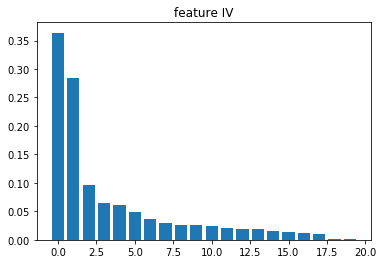

In [21]:
# 将变量IV值进行降.,序排列，方便后续挑选变量
IV_dict_sorted = sorted(IV_dict.items(), key=lambda x: x[1], reverse=True)

IV_values = [i[1] for i in IV_dict_sorted]
IV_name = [i[0] for i in IV_dict_sorted]
plt.title('feature IV')
plt.bar(range(len(IV_values)), IV_values)
plt.show()


In [23]:
'''
第五步：单变量分析和多变量分析，均基于WOE编码后的值。
（1）选择IV高于0.01的变量
（2）比较两两线性相关性。如果相关系数的绝对值高于阈值，剔除IV较低的一个
'''

# 选取IV>0.02的变量
high_IV = {k: v for k, v in IV_dict.items() if v >= 0.02}
high_IV_sorted = sorted(high_IV.items(), key=lambda x: x[1], reverse=True)

short_list = high_IV.keys()
short_list_2 = []
for var in short_list:
    newVar = var + '_WOE'
    trainData[newVar] = trainData[var].map(WOE_dict[var])
    short_list_2.append(newVar)

In [24]:
short_list_2

['pub_rec_bankruptcies_clean_Bin_WOE',
 'int_rate_clean_Bin_WOE',
 'annual_inc_Bin_WOE',
 'earliest_cr_to_app_Bin_WOE',
 'inq_last_6mths_Bin_WOE',
 'mths_since_last_record_clean_Bin_WOE',
 'open_acc_Bin_WOE',
 'pub_rec_Bin_WOE',
 'total_acc_Bin_WOE',
 'purpose_br_encoding_Bin_WOE',
 'zip_code_br_encoding_Bin_WOE',
 'addr_state_br_encoding_Bin_WOE']

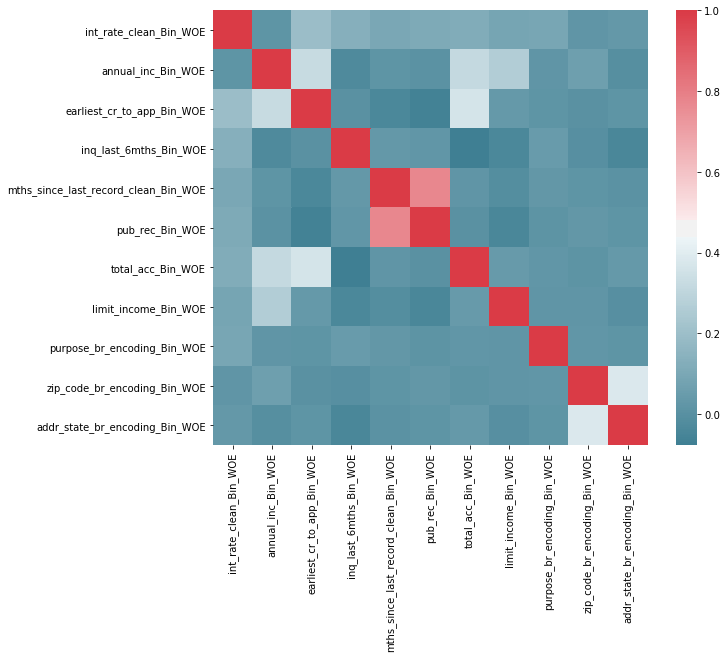

In [81]:
# 对于上一步的结果，计算相关系数矩阵，并画出热力图进行数据可视化
trainDataWOE = trainData[short_list_2]
f, ax = plt.subplots(figsize=(10, 8))
corr = trainDataWOE.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [25]:
# 两两间的线性相关性检验
# 1，将候选变量按照IV进行降序排列
# 2，计算第i和第i+1的变量的线性相关系数
# 3，对于系数超过阈值的两个变量，剔除IV较低的一个
deleted_index = []
cnt_vars = len(high_IV_sorted)
for i in range(cnt_vars):
    if i in deleted_index:
        continue
    x1 = high_IV_sorted[i][0] + "_WOE"  # 'newVarWOe'
    for j in range(cnt_vars):
        if i == j or j in deleted_index:
            continue
        y1 = high_IV_sorted[j][0] + "_WOE"
        roh = np.corrcoef(trainData[x1], trainData[y1])[0, 1]
        if abs(roh) > 0.7:
            x1_IV = high_IV_sorted[i][1]
            y1_IV = high_IV_sorted[j][1]
            if x1_IV > y1_IV:
                deleted_index.append(j)
            else:
                deleted_index.append(i)

multi_analysis_vars_1 = [high_IV_sorted[i][0] + "_WOE" for i in range(cnt_vars) if i not in deleted_index]

In [26]:
multi_analysis_vars_1

['zip_code_br_encoding_Bin_WOE',
 'int_rate_clean_Bin_WOE',
 'purpose_br_encoding_Bin_WOE',
 'annual_inc_Bin_WOE',
 'inq_last_6mths_Bin_WOE',
 'addr_state_br_encoding_Bin_WOE',
 'mths_since_last_record_clean_Bin_WOE',
 'earliest_cr_to_app_Bin_WOE',
 'total_acc_Bin_WOE',
 'open_acc_Bin_WOE']

In [27]:
'''
多变量分析：VIF
'''
X = np.matrix(trainData[multi_analysis_vars_1])
VIF_list = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
max_VIF = max(VIF_list)
print(max_VIF)
# 最大的VIF是1.32267733123，因此这一步认为没有多重共线性
multi_analysis = multi_analysis_vars_1

1.3551931324374742


In [28]:
'''
第六步：逻辑回归模型。
要求：
1，变量显著
2，符号为负
'''
### (1)将多变量分析的后变量带入LR模型中
y = trainData['y']
X = trainData[multi_analysis]
X['intercept'] = [1] * X.shape[0]

LR = sm.Logit(y, X).fit()
summary = LR.summary()
print(summary)
pvals = LR.pvalues
pvals = pvals.to_dict()
print(pvals)


Optimization terminated successfully.
         Current function value: 0.310091
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                17457
Model:                          Logit   Df Residuals:                    17446
Method:                           MLE   Df Model:                           10
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.1169
Time:                        19:54:36   Log-Likelihood:                -5413.3
converged:                       True   LL-Null:                       -6129.7
Covariance Type:            nonrobust   LLR p-value:                8.202e-302
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
zip_code_br_encoding_Bin_WOE            -0.9569      0.0

In [29]:
# 有些变量不显著，需要逐步剔除
varLargeP = {k: v for k, v in pvals.items() if v >= 0.1}
varLargeP = sorted(varLargeP.items(), key=lambda d: d[1], reverse=True)
while (len(varLargeP) > 0 and len(multi_analysis) > 0):
    # 每次迭代中，剔除最不显著的变量，直到
    # (1) 剩余所有变量均显著
    # (2) 没有特征可选
    varMaxP = varLargeP[0][0]
    print(varMaxP)
    if varMaxP == 'intercept':
        print('the intercept is not significant!')
        break
    multi_analysis.remove(varMaxP)
    y = trainData['y']
    X = trainData[multi_analysis]
    X['intercept'] = [1] * X.shape[0]

    LR = sm.Logit(y, X).fit()
    pvals = LR.pvalues
    pvals = pvals.to_dict()
    varLargeP = {k: v for k, v in pvals.items() if v >= 0.1}
    varLargeP = sorted(varLargeP.items(), key=lambda d: d[1], reverse=True)

total_acc_Bin_WOE
Optimization terminated successfully.
         Current function value: 0.310091
         Iterations 7
earliest_cr_to_app_Bin_WOE
Optimization terminated successfully.
         Current function value: 0.310092
         Iterations 7
addr_state_br_encoding_Bin_WOE
Optimization terminated successfully.
         Current function value: 0.310163
         Iterations 7


In [32]:
summary = LR.summary()
trainData['prob'] = LR.predict(X)
ks = KS(trainData, 'prob', 'y')
auc = roc_auc_score(trainData['y'], trainData['prob'])
print('normalLR:ks {}, auc {}'.format(ks, auc))

total  bad  good     score
prob                                
0.003475     11    0    11  0.003475
0.004103     19    0    19  0.004103
0.004467      5    0     5  0.004467
0.004579     11    0    11  0.004579
0.005209     11    0    11  0.005209
...         ...  ...   ...       ...
0.721648      1    0     1  0.721648
0.742447      1    1     0  0.742447
0.752654      1    1     0  0.752654
0.766871      1    0     1  0.766871
0.774640      1    1     0  0.774640

[2502 rows x 4 columns]
normalLR:ks 0.36103062846423695, auc 0.7459362109725037


In [31]:
def KS(df, score, target):
    '''
    :param df: 包含目标变量与预测值的数据集
    :param score: 得分或者概率
    :param target: 目标变量
    :return: KS值
    '''
    total = df.groupby([score])[target].count()
    bad = df.groupby([score])[target].sum()
    all = pd.DataFrame({'total':total, 'bad':bad})
    all['good'] = all['total'] - all['bad']
    all['score'] = all.index
    print(all)
    all = all.sort_values(by='score',ascending=False)
    all.index = range(len(all))
    all['badCumRate'] = all['bad'].cumsum() / all['bad'].sum()
    all['goodCumRate'] = all['good'].cumsum() / all['good'].sum()
    KS = all.apply(lambda x: x.badCumRate - x.goodCumRate, axis=1)
    return max(KS)

In [131]:
# 将模型保存
saveModel = open(folderOfData + 'LR_Model_Normal.pkl', 'wb+')
pickle.dump(LR, saveModel)
saveModel.close()

In [30]:
trainData.to_excel('train_data.xlsx',index=None)

In [41]:
from sklearn.linear_model import LogisticRegression
'''
第六步：逻辑回归模型。
要求：
1，变量显著
2，符号为负
'''
### (1)将多变量分析的后变量带入LR模型中
y = trainData['y']
x = trainData[multi_analysis]


lr_model = LogisticRegression(C=0.1)
lr_model.fit(x,y)
trainData['prob'] = lr_model.predict_proba(x)[:,1]

In [43]:
from sklearn import metrics 
from sklearn.model_selection import train_test_split,cross_val_score 

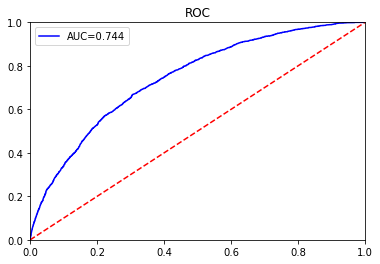

In [44]:
def plot_roc(y_label,y_pred):
    """
    y_label:测试集的y
    y_pred:对测试集预测后的概率
    
    return:ROC曲线
    """
    tpr,fpr,threshold = metrics.roc_curve(y_label,y_pred) 
    AUC = metrics.roc_auc_score(y_label,y_pred) 
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1,1,1)
    ax.plot(tpr,fpr,color='blue',label='AUC=%.3f'%AUC) 
    ax.plot([0,1],[0,1],'r--')
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    ax.set_title('ROC')
    ax.legend(loc='best')
    return plt.show(ax)
plot_roc(trainData['y'],trainData['prob'])

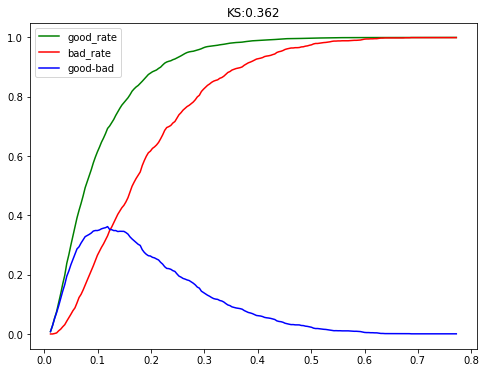

In [45]:
def plot_model_ks(y_label,y_pred):
    """
    y_label:测试集的y
    y_pred:对测试集预测后的概率
    
    return:KS曲线
    """
    pred_list = list(y_pred) 
    label_list = list(y_label)
    total_bad = sum(label_list)
    total_good = len(label_list)-total_bad 
    items = sorted(zip(pred_list,label_list),key=lambda x:x[0]) 
    step = (max(pred_list)-min(pred_list))/200 
    
    pred_bin=[]
    good_rate=[] 
    bad_rate=[] 
    ks_list = [] 
    for i in range(1,201): 
        idx = min(pred_list)+i*step 
        pred_bin.append(idx) 
        label_bin = [x[1] for x in items if x[0]<idx] 
        bad_num = sum(label_bin)
        good_num = len(label_bin)-bad_num  
        goodrate = good_num/total_good 
        badrate = bad_num/total_bad
        ks = abs(goodrate-badrate) 
        good_rate.append(goodrate)
        bad_rate.append(badrate)
        ks_list.append(ks)
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    ax.plot(pred_bin,good_rate,color='green',label='good_rate')
    ax.plot(pred_bin,bad_rate,color='red',label='bad_rate')
    ax.plot(pred_bin,ks_list,color='blue',label='good-bad')
    ax.set_title('KS:{:.3f}'.format(max(ks_list)))
    ax.legend(loc='best')
    return plt.show(ax)
plot_model_ks(trainData['y'],trainData['prob'])

CV的最大AUC为:0.7566792671504714
CV的最小AUC为:0.72023370638578
CV的平均AUC为:0.7376480891245021


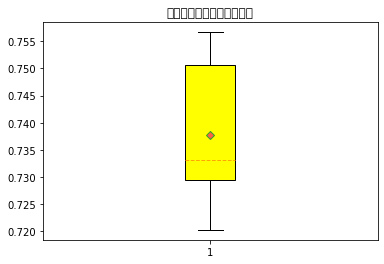

In [59]:
from sklearn import datasets, linear_model
# 交叉验证
def cross_verify(x,y,estimators,fold,scoring='roc_auc'):
    """
    x:自变量的数据集
    y:target的数据集
    estimators：验证的模型
    fold：交叉验证的策略
    scoring:评级指标，默认auc
    
    return:交叉验证的结果
    """
    cv_result = cross_val_score(estimator=estimators,X=x,y=y,cv=fold,n_jobs=-1,scoring=scoring)
    print('CV的最大AUC为:{}'.format(cv_result.max()))
    print('CV的最小AUC为:{}'.format(cv_result.min()))
    print('CV的平均AUC为:{}'.format(cv_result.mean()))
    plt.figure(figsize=(6,4))
    plt.title('交叉验证的评价指标分布图')
    plt.boxplot(cv_result,patch_artist=True,showmeans=True,
            boxprops={'color':'black','facecolor':'yellow'},
            meanprops={'marker':'D','markerfacecolor':'tomato'},
            flierprops={'marker':'o','markerfacecolor':'red','color':'black'},
            medianprops={'linestyle':'--','color':'orange'})
    return plt.show()
cross_verify(X,y,LinearRegression(),10)

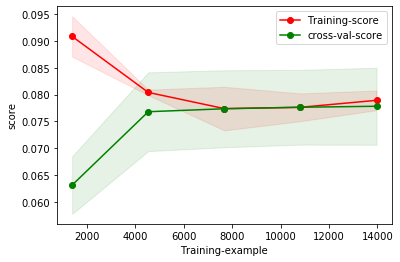

In [46]:
from sklearn.linear_model import LinearRegression
# 学习曲线
def plot_learning_curve(estimator,x,y,cv=None,train_size = np.linspace(0.1,1.0,5),plt_size =None):
    """
    estimator :画学习曲线的基模型
    x:自变量的数据集
    y:target的数据集
    cv:交叉验证的策略
    train_size:训练集划分的策略
    plt_size:画图尺寸
    
    return:学习曲线
    """
    from sklearn.model_selection import learning_curve
    train_sizes,train_scores,test_scores = learning_curve(estimator=estimator,
                                                          X=x,
                                                          y=y,
                                                          cv=cv,
                                                          n_jobs=-1,
                                                          train_sizes=train_size)
    train_scores_mean = np.mean(train_scores,axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores,axis=1)
    test_scores_std = np.std(test_scores,axis=1)
    plt.figure(figsize=plt_size)
    plt.xlabel('Training-example')
    plt.ylabel('score')
    plt.fill_between(train_sizes,train_scores_mean-train_scores_std,
                     train_scores_mean+train_scores_std,alpha=0.1,color='r')
    plt.fill_between(train_sizes,test_scores_mean-test_scores_std,
                     test_scores_mean+test_scores_std,alpha=0.1,color='g')
    plt.plot(train_sizes,train_scores_mean,'o-',color='r',label='Training-score')
    plt.plot(train_sizes,test_scores_mean,'o-',color='g',label='cross-val-score')
    plt.legend(loc='best')
    return plt.show()
plot_learning_curve(LinearRegression(),X,y,cv=None,train_size = np.linspace(0.1,1.0,5),plt_size =None)

precision    recall  f1-score   support

           0       0.89      1.00      0.94     15524
           1       0.58      0.03      0.05      1933

    accuracy                           0.89     17457
   macro avg       0.74      0.51      0.50     17457
weighted avg       0.86      0.89      0.84     17457



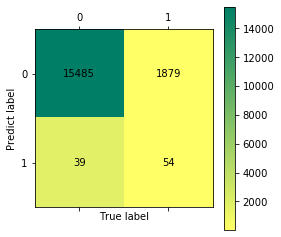

In [57]:
# 混淆矩阵 /分类报告
def plot_matrix_report(y_label,y_pred): 
    """
    y_label:测试集的y
    y_pred:对测试集预测后的概率
    
    return:混淆矩阵
    """
    matrix_array = metrics.confusion_matrix(y_label,y_pred)
    plt.matshow(matrix_array, cmap=plt.cm.summer_r)
    plt.colorbar()

    for x in range(len(matrix_array)): 
        for y in range(len(matrix_array)):
            plt.annotate(matrix_array[x,y], xy =(x,y), ha='center',va='center')

    plt.xlabel('True label')
    plt.ylabel('Predict label')
    print(metrics.classification_report(y_label,y_pred))
    return plt.show()
plot_matrix_report(trainData['y'],trainData['prob'].round())

In [88]:
# 评分卡刻度 
def cal_scale(score,odds,PDO,model):
    """
    odds：设定的坏好比
    score:在这个odds下的分数
    PDO: 好坏翻倍比
    model:逻辑回归模型
    
    return :A,B,base_score
    """
    B = PDO/np.log(2)
    A = score+B*np.log(odds)
    # base_score = A+B*model.intercept_[0]
    print('B: {:.2f}'.format(B))
    print('A: {:.2f}'.format(A))
    # print('基础分为：{:.2f}'.format(base_score))
    return A,B
cal_scale(50,0.05,10,lr_model)

B: 14.43
A: 6.78


(6.7807190511263755, 14.426950408889635)

In [90]:
def Prob2Score(prob, A,B):
    #将概率转化成分数且为正整数
    y = np.log(prob/(1-prob))
    return float(A-B*y)

In [91]:
trainData['score'] = trainData['prob'].map(lambda x:Prob2Score(x,6.78,14.43))

In [94]:
trainData['score'].min()

-10.826940593804512

In [95]:
# 得分的KS 
def plot_score_ks(df,score_col,target):
    """
    df:数据集
    target:目标变量的字段名
    score_col:最终得分的字段名
    """
    total_bad = df[target].sum()
    total_good = df[target].count()-total_bad
    score_list = list(df[score_col])
    target_list = list(df[target])
    items = sorted(zip(score_list,target_list),key=lambda x:x[0]) 
    step = (max(score_list)-min(score_list))/200 
    
    score_bin=[] 
    good_rate=[] 
    bad_rate=[] 
    ks_list = [] 
    for i in range(1,201):
        idx = min(score_list)+i*step 
        score_bin.append(idx) 
        target_bin = [x[1] for x in items if x[0]<idx]  
        bad_num = sum(target_bin)
        good_num = len(target_bin)-bad_num 
        goodrate = good_num/total_good 
        badrate = bad_num/total_bad
        ks = abs(goodrate-badrate) 
        good_rate.append(goodrate)
        bad_rate.append(badrate)
        ks_list.append(ks)
        
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    ax.plot(score_bin,good_rate,color='green',label='good_rate')
    ax.plot(score_bin,bad_rate,color='red',label='bad_rate')
    ax.plot(score_bin,ks_list,color='blue',label='good-bad')
    ax.set_title('KS:{:.3f}'.format(max(ks_list)))
    ax.legend(loc='best')
    return plt.show(ax)

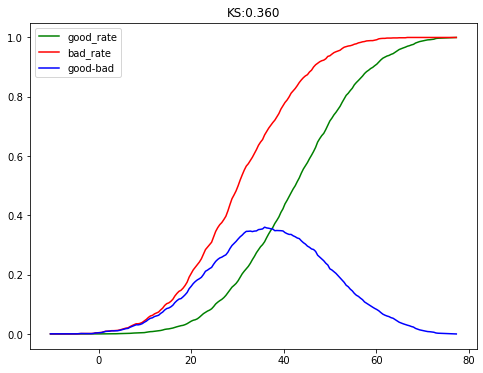

In [96]:
plot_score_ks(trainData,'score','y')

In [97]:
import matplotlib.pyplot as plt
 
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）

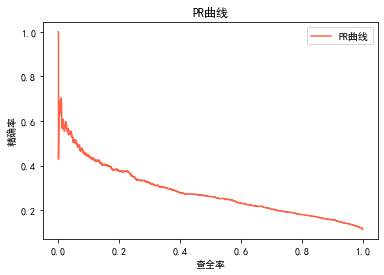

In [98]:
# PR曲线
def plot_PR(df,score_col,target,plt_size=None):
    """
    df:得分的数据集
    score_col:分数的字段名
    target:目标变量的字段名
    plt_size:绘图尺寸
    
    return: PR曲线
    """
    total_bad = df[target].sum()
    score_list = list(df[score_col])
    target_list = list(df[target])
    score_unique_list = sorted(set(list(df[score_col])))
    items = sorted(zip(score_list,target_list),key=lambda x:x[0]) 

    precison_list = []
    tpr_list = []
    for score in score_unique_list:
        target_bin = [x[1] for x in items if x[0]<=score]  
        bad_num = sum(target_bin)
        total_num = len(target_bin)
        precison = bad_num/total_num
        tpr = bad_num/total_bad
        precison_list.append(precison)
        tpr_list.append(tpr)
    
    plt.figure(figsize=plt_size)
    plt.title('PR曲线')
    plt.xlabel('查全率')
    plt.ylabel('精确率')
    plt.plot(tpr_list,precison_list,color='tomato',label='PR曲线')
    plt.legend(loc='best')
    return plt.show()
plot_PR(trainData,'score','y',plt_size=None)

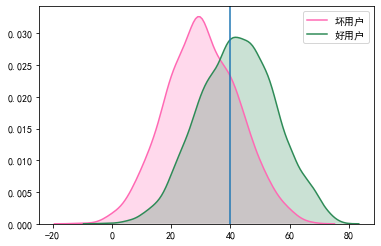

In [102]:
# 得分分布图
def plot_score_hist(df,target,score_col,plt_size=None,cutoff=None):
    """
    df:数据集
    target:目标变量的字段名
    score_col:最终得分的字段名
    plt_size:图纸尺寸
    cutoff :划分拒绝/通过的点
    
    return :好坏用户的得分分布图
    """    
    plt.figure(figsize=plt_size)
    x1 = df[df[target]==1][score_col]
    x2 = df[df[target]==0][score_col]
    sns.kdeplot(x1,shade=True,label='坏用户',color='hotpink')
    sns.kdeplot(x2,shade=True,label='好用户',color ='seagreen')
    plt.axvline(x=cutoff)
    plt.legend()
    return plt.show()
plot_score_hist(trainData,'y','score',plt_size=None,cutoff=40)

In [68]:
# 得分明细表 
def score_info(df,score_col,target,x=None,y=None,step=None):
    """
    df:数据集
    target:目标变量的字段名
    score_col:最终得分的字段名
    x:最小区间的左值
    y:最大区间的右值
    step:区间的分数间隔
    
    return :得分明细表
    """
    df['score_bin'] = pd.cut(df[score_col],bins=np.arange(x,y,step),right=True)
    total = df[target].count()
    bad = df[target].sum()
    good = total - bad
    
    group = df.groupby('score_bin')
    score_info_df = pd.DataFrame()
    score_info_df['用户数'] = group[target].count()
    score_info_df['坏用户'] = group[target].sum()
    score_info_df['好用户'] = score_info_df['用户数']-score_info_df['坏用户']
    score_info_df['违约占比'] = score_info_df['坏用户']/score_info_df['用户数']
    score_info_df['累计用户'] = score_info_df['用户数'].cumsum()
    score_info_df['坏用户累计'] = score_info_df['坏用户'].cumsum()
    score_info_df['好用户累计'] = score_info_df['好用户'].cumsum()
    score_info_df['坏用户累计占比'] = score_info_df['坏用户累计']/bad 
    score_info_df['好用户累计占比'] = score_info_df['好用户累计']/good
    score_info_df['累计用户占比'] = score_info_df['累计用户']/total 
    score_info_df['累计违约占比'] = score_info_df['坏用户累计']/score_info_df['累计用户']
    score_info_df = score_info_df.reset_index()
    return score_info_df
score_info(trainData,'score','y',x=0,y=100,step=10)

,score_bin,用户数,坏用户,好用户,违约占比,累计用户,坏用户累计,好用户累计,坏用户累计占比,好用户累计占比,累计用户占比,累计违约占比
0,"(0, 10]",118,60,58,0.508475,118,60,58,0.030380,0.003746,0.006759,0.508475
1,"(10, 20]",468,180,288,0.384615,586,240,346,0.121519,0.022349,0.033568,0.409556
2,"(20, 30]",1160,316,844,0.272414,1746,556,1190,0.281519,0.076863,0.100017,0.318442
3,"(30, 40]",2139,435,1704,0.203366,3885,991,2894,0.501772,0.186927,0.222547,0.255084
4,"(40, 50]",2951,385,2566,0.130464,6836,1376,5460,0.696709,0.352668,0.391591,0.201287
5,"(50, 60]",3492,311,3181,0.089061,10328,1687,8641,0.854177,0.558132,0.591625,0.163342
6,"(60, 70]",3092,171,2921,0.055304,13420,1858,11562,0.940759,0.746803,0.768746,0.138450
7,"(70, 80]",2257,73,2184,0.032344,15677,1931,13746,0.977722,0.887870,0.898035,0.123174
8,"(80, 90]",1132,20,1112,0.017668,16809,1951,14858,0.987848,0.959695,0.962880,0.116069


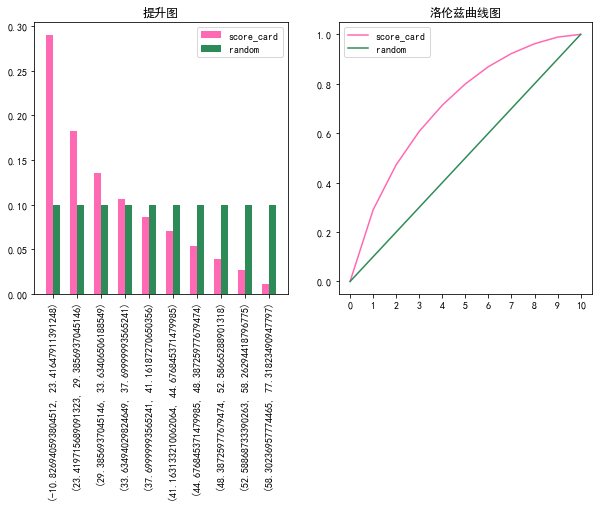

In [106]:
# 绘制提升图和洛伦兹曲线
def plot_lifting(df,score_col,target,bins=10,plt_size=None):
    """
    df:数据集，包含最终的得分
    score_col:最终分数的字段名
    target:目标变量名
    bins:分数划分成的等份数
    plt_size:绘图尺寸
    
    return:提升图和洛伦兹曲线
    """
    score_list = list(df[score_col])
    label_list = list(df[target])
    items = sorted(zip(score_list,label_list),key = lambda x:x[0])
    step = round(df.shape[0]/bins,0)
    bad = df[target].sum()
    all_badrate = float(1/bins)
    all_badrate_list = [all_badrate]*bins
    all_badrate_cum = list(np.cumsum(all_badrate_list))
    all_badrate_cum.insert(0,0)
    
    score_bin_list=[]
    bad_rate_list = []
    for i in range(0,bins,1):
        index_a = int(i*step)
        index_b = int((i+1)*step)
        score = [x[0] for x in items[index_a:index_b]]
        tup1 = (min(score),)
        tup2 = (max(score),)
        score_bin = tup1+tup2
        score_bin_list.append(score_bin)
        label_bin = [x[1] for x in items[index_a:index_b]]
        bin_bad = sum(label_bin)
        bin_bad_rate = bin_bad/bad
        bad_rate_list.append(bin_bad_rate)
    bad_rate_cumsum = list(np.cumsum(bad_rate_list))
    bad_rate_cumsum.insert(0,0)
    
    plt.figure(figsize=plt_size)
    x = score_bin_list
    y1 = bad_rate_list
    y2 = all_badrate_list
    y3 = bad_rate_cumsum
    y4 = all_badrate_cum
    plt.subplot(1,2,1)
    plt.title('提升图')
    plt.xticks(np.arange(bins)+0.15,x,rotation=90)
    bar_width= 0.3
    plt.bar(np.arange(bins),y1,width=bar_width,color='hotpink',label='score_card')
    plt.bar(np.arange(bins)+bar_width,y2,width=bar_width,color='seagreen',label='random')
    plt.legend(loc='best')
    plt.subplot(1,2,2)
    plt.title('洛伦兹曲线图')
    plt.plot(y3,color='hotpink',label='score_card')
    plt.plot(y4,color='seagreen',label='random')
    plt.xticks(np.arange(bins+1),rotation=0)
    plt.legend(loc='best')
    return plt.show()
plot_lifting(trainData,'score','y',bins=10,plt_size=(10,5))

In [109]:
# 设定cutoff点，衡量有效性
def rule_verify(df,col_score,target,cutoff):
    """
    df:数据集
    target:目标变量的字段名
    col_score:最终得分的字段名    
    cutoff :划分拒绝/通过的点
    
    return :混淆矩阵
    """
    df['result'] = df.apply(lambda x:30 if x[col_score]<=cutoff else 10,axis=1)
    TP = df[(df['result']==30)&(df[target]==1)].shape[0] 
    FN = df[(df['result']==30)&(df[target]==0)].shape[0] 
    bad = df[df[target]==1].shape[0] 
    good = df[df[target]==0].shape[0] 
    refuse = df[df['result']==30].shape[0] 
    passed = df[df['result']==10].shape[0] 
    
    acc = round(TP/refuse,3) 
    tpr = round(TP/bad,3) 
    fpr = round(FN/good,3) 
    pass_rate = round(refuse/df.shape[0],3) 
    matrix_df = pd.pivot_table(df,index='result',columns=target,aggfunc={col_score:pd.Series.count},values=col_score) 
    
    print('精确率:{}'.format(acc))
    print('查全率:{}'.format(tpr))
    print('误伤率:{}'.format(fpr))
    print('规则拒绝率:{}'.format(pass_rate))
    return matrix_df
rule_verify(trainData,'score','y',30)

精确率:0.262
查全率:0.491
误伤率:0.176
规则拒绝率:0.212


y,0,1
result,,
10,12752.0,1005.0
30,2730.0,970.0


In [110]:
trainData.head()

,member_id,loan_amnt,term,loan_status,int_rate,emp_length,home_ownership,annual_inc,verification_status,desc,...,open_acc_Bin_WOE,pub_rec_Bin_WOE,total_acc_Bin_WOE,purpose_br_encoding_Bin_WOE,zip_code_br_encoding_Bin_WOE,addr_state_br_encoding_Bin_WOE,prob,score,score_bin,result
1515,1516,18000,36,Fully Paid,10.65%,10+ years,RENT,63000.0,Source Verified,Borrower added on 12/02/11 > A Bill Consolid...,...,0.058044,0.04265,-0.167048,0.032039,0.882661,0.285155,0.032574,55.713754,"(70.0, 80.0]",10
37785,37786,15000,36,Fully Paid,9.63%,2 years,RENT,55000.0,Not Verified,This loan will be used to eliminate my revolvi...,...,0.058044,0.04265,0.131183,0.380959,-0.418997,-0.163065,0.081380,41.754597,"(50.0, 60.0]",10
32355,32356,8000,36,Fully Paid,13.11%,2 years,RENT,48000.0,Not Verified,Borrower added on 02/10/10 > Thanks for read...,...,0.058044,0.04265,-0.167048,0.380959,0.882661,0.066323,0.047551,50.030140,"(60.0, 70.0]",10
11199,11200,15000,36,Fully Paid,5.99%,10+ years,MORTGAGE,95200.0,Not Verified,Borrower added on 07/17/11 > looking to pay ...,...,0.058044,0.04265,-0.167048,-0.221079,0.882661,0.066323,0.014988,67.174985,NaN,10
38523,38525,7500,36,Fully Paid,14.75%,1 year,RENT,30000.0,Not Verified,our company provides stores with a unique serv...,...,0.058044,0.04265,0.131183,0.380959,-0.039690,-0.163065,0.172705,29.385694,"(30.0, 40.0]",30


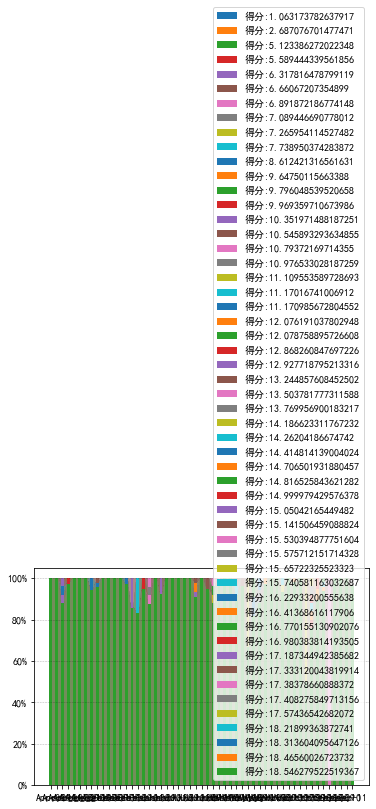

In [115]:
# 绘制变量的得分占比偏移图
def plot_var_shift(df,day_col,score_col,plt_size=None):
    """
    df:变量在一段时间内，每个区间上的得分
    day_col:时间的字段名（天）
    score_col:得分的字段名
    plt_size: 绘图尺寸
    
    return:变量区间得分的偏移图
    """
    day_list = sorted(set(list(df[day_col]))) 
    score_list = sorted(set(list(df[score_col])))
    # 计算每天各个区间得分的占比
    prop_day_list = []
    for day in day_list:
        prop_list = []
        for score in score_list:
            prop = df[(df[day_col]==day)&(df[score_col]==score)].shape[0]/df[df[day_col]==day].shape[0]
            prop_list.append(prop)
        prop_day_list.append(prop_list)
    
    # 将得分占比的转化为画图的格式
    sub_list = []
    for p in prop_day_list:
        p_cumsum = list(np.cumsum(p))
        p_cumsum = p_cumsum[:-1]
        p_cumsum.insert(0,0)
        bar1_list = [1]*int(len(p_cumsum))
        sub = [bar1_list[i]-p_cumsum[i] for i in range(len(p_cumsum))]
        sub_list.append(sub)
    array = np.array(sub_list)
    
    stack_prop_list = [] # 面积图的y值
    bar_prop_list = [] # 堆积柱状图的y
    for i in range(len(score_list)):
        bar_prop = array[:,i]
        bar_prop_list.append(bar_prop)
        stack_prop = []
        for j in bar_prop:
            a = j
            b = j
            stack_prop.append(a)
            stack_prop.append(b)
        stack_prop_list.append(stack_prop)
    
    # 画图的x坐标轴
    x_bar = list(range(1,len(day_list)*2,2)) # 堆积柱状图的x值
    x_stack = []    # 面积图的x值
    for i in x_bar:
        c = i-0.5
        d = i+0.5
        x_stack.append(c)
        x_stack.append(d)
    
    # 绘图
    fig = plt.figure(figsize=plt_size)
    ax1 = fig.add_subplot(1,1,1)
    # 先清除x轴的刻度
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(''.format)) 
    ax1.set_xticks(range(1,len(day_list)*2,2))
    # 将y轴的刻度设置为百分比形式
    def to_percent(temp, position):
        return '%1.0f'%(100*temp) + '%'
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(to_percent))
    # 自定义x轴刻度标签
    for a,b in zip(x_bar,day_list): 
        ax1.text(a,-0.08,b,ha='center',va='bottom')
    # 绘制面积图和堆积柱状图
    for i,s in zip(range(len(day_list)),score_list):
        ax1.stackplot(x_stack,stack_prop_list[i],alpha=0.25)
        ax1.bar(x_bar,bar_prop_list[i],width=1,label='得分:{}'.format(s))
        # 添加y轴刻度虚线
        ax1.grid(True, 'major', 'y', ls='--', lw=.5, c='black', alpha=.3)
        ax1.legend(loc='best')
    plt.show()
plot_var_shift(trainData.iloc[1:1000],'issue_d','score',plt_size=None)

In [117]:
# 计算评分的PSI
def score_psi(df1,df2,id_col,score_col,x,y,step=None):
    """
    df1:建模样本的得分,包含用户id,得分
    df2:上线样本的得分，包含用户id，得分
    id_col:用户id字段名
    score_col:得分的字段名
    x:划分得分区间的left值
    y:划分得分区间的right值
    step:步长
    
    return: 得分psi表
    """
    df1['score_bin'] = pd.cut(df1[score_col],bins=np.arange(x,y,step))
    model_score_group = df1.groupby('score_bin',as_index=False)[id_col].count().                           assign(pct=lambda x:x[id_col]/x[id_col].sum()).                           rename(columns={id_col:'建模样本户数',
                                           'pct':'建模户数占比'})
    df2['score_bin'] = pd.cut(df2[score_col],bins=np.arange(x,y,step))
    online_score_group = df2.groupby('score_bin',as_index=False)[id_col].count().                           assign(pct=lambda x:x[id_col]/x[id_col].sum()).                           rename(columns={id_col:'线上样本户数',
                                           'pct':'线上户数占比'})
    score_compare = pd.merge(model_score_group,online_score_group,on='score_bin',how='inner')
    score_compare['占比差异'] = score_compare['线上户数占比'] - score_compare['建模户数占比']
    score_compare['占比权重'] = np.log(score_compare['线上户数占比']/score_compare['建模户数占比'])
    score_compare['Index']= score_compare['占比差异']*score_compare['占比权重']
    score_compare['PSI'] = score_compare['Index'].sum()
    return score_compare
score_psi(trainData.iloc[1:5000],trainData.iloc[5000:10000],'member_id','score',x=0,y=100,step=5)

,score_bin,建模样本户数,建模户数占比,线上样本户数,线上户数占比,占比差异,占比权重,Index,PSI
0,"(0, 5]",10,0.002002,10,0.002000,-0.000002,-0.000800,1.282307e-09,0.008335
1,"(5, 10]",28,0.005606,34,0.006801,0.001196,0.193356,2.312058e-04,0.008335
2,"(10, 15]",93,0.018619,81,0.016203,-0.002415,-0.138951,3.356187e-04,0.008335
3,"(15, 20]",171,0.034234,166,0.033207,-0.001028,-0.030476,3.131718e-05,0.008335
4,"(20, 25]",298,0.059660,294,0.058812,-0.000848,-0.014314,1.213697e-05,0.008335
5,"(25, 30]",455,0.091091,435,0.087017,-0.004074,-0.045752,1.863788e-04,0.008335
6,"(30, 35]",610,0.122122,629,0.125825,0.003703,0.029872,1.106166e-04,0.008335
7,"(35, 40]",642,0.128529,684,0.136827,0.008299,0.062569,5.192510e-04,0.008335
8,"(40, 45]",700,0.140140,710,0.142028,0.001888,0.013384,2.527284e-05,0.008335
9,"(45, 50]",681,0.136336,689,0.137828,0.001491,0.010878,1.622231e-05,0.008335


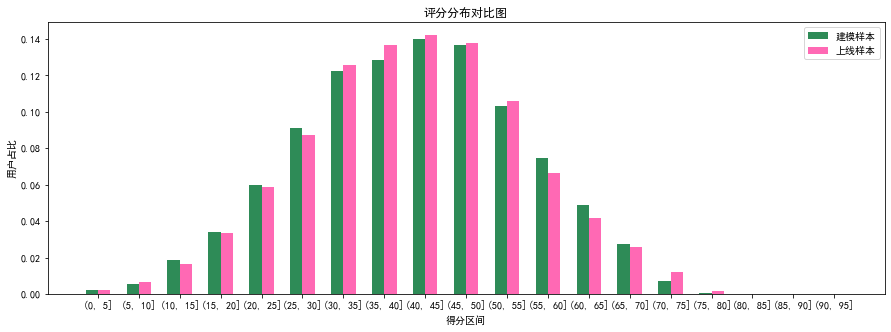

In [123]:
# 评分比较分布图
def plot_score_compare(df,plt_size=None):
    fig = plt.figure(figsize=plt_size)
    x = df.score_bin
    y1 = df.建模户数占比
    y2 = df.线上户数占比
    width=0.3
    plt.title('评分分布对比图')
    plt.xlabel('得分区间')
    plt.ylabel('用户占比')
    plt.xticks(np.arange(len(x))+0.15,x)
    plt.bar(np.arange(len(y1)),y1,width=width,color='seagreen',label='建模样本')
    plt.bar(np.arange(len(y2))+width,y2,width=width,color='hotpink',label='上线样本')
    plt.legend()
    return plt.show() 
df=score_psi(trainData.iloc[1:5000],trainData.iloc[5000:10000],'member_id','score',x=0,y=100,step=5)
plot_score_compare(df,plt_size=(15,5))

In [125]:
trainData.head()

,member_id,loan_amnt,term,loan_status,int_rate,emp_length,home_ownership,annual_inc,verification_status,desc,...,open_acc_Bin_WOE,pub_rec_Bin_WOE,total_acc_Bin_WOE,purpose_br_encoding_Bin_WOE,zip_code_br_encoding_Bin_WOE,addr_state_br_encoding_Bin_WOE,prob,score,score_bin,result
1515,1516,18000,36,Fully Paid,10.65%,10+ years,RENT,63000.0,Source Verified,Borrower added on 12/02/11 > A Bill Consolid...,...,0.058044,0.04265,-0.167048,0.032039,0.882661,0.285155,0.032574,55.713754,"(50, 60]",10
37785,37786,15000,36,Fully Paid,9.63%,2 years,RENT,55000.0,Not Verified,This loan will be used to eliminate my revolvi...,...,0.058044,0.04265,0.131183,0.380959,-0.418997,-0.163065,0.081380,41.754597,"(40, 50]",10
32355,32356,8000,36,Fully Paid,13.11%,2 years,RENT,48000.0,Not Verified,Borrower added on 02/10/10 > Thanks for read...,...,0.058044,0.04265,-0.167048,0.380959,0.882661,0.066323,0.047551,50.030140,"(50, 60]",10
11199,11200,15000,36,Fully Paid,5.99%,10+ years,MORTGAGE,95200.0,Not Verified,Borrower added on 07/17/11 > looking to pay ...,...,0.058044,0.04265,-0.167048,-0.221079,0.882661,0.066323,0.014988,67.174985,"(60, 70]",10
38523,38525,7500,36,Fully Paid,14.75%,1 year,RENT,30000.0,Not Verified,our company provides stores with a unique serv...,...,0.058044,0.04265,0.131183,0.380959,-0.039690,-0.163065,0.172705,29.385694,"(20, 30]",30


In [126]:
score_info=score_info(trainData,'score','y',x=0,y=100,step=10)

In [127]:
score_result=pd.merge(trainData,score_info,on=['score_bin']).rename(colmuns={'score_bin':'bin','用户数':'total',})

In [129]:
score_result.columns

Index(['member_id', 'loan_amnt', 'term', 'loan_status', 'int_rate',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'pub_rec_bankruptcies', 'issue_d', 'earliest_cr_line', 'y',
       'int_rate_clean', 'emp_length_clean', 'desc_clean', 'app_date_clean',
       'earliest_cr_line_clean', 'mths_since_last_delinq_clean',
       'mths_since_last_record_clean', 'pub_rec_bankruptcies_clean',
       'limit_income', 'earliest_cr_to_app', 'home_ownership_Bin',
       'pub_rec_bankruptcies_clean_Bin', 'purpose_br_encoding',
       'zip_code_br_encoding', 'addr_state_br_encoding', 'int_rate_clean_Bin',
       'emp_length_clean_Bin', 'annual_inc_Bin', 'dti_Bin', 'delinq_2yrs_Bin',
       'earliest_cr_to_app_Bin', 'inq_last_6mths_Bin',
       'mths_since_last_record_

In [128]:
# 变量稳定度分析
def var_stable(score_result,df,var,id_col,score_col,bins):
    """
    score_result:评分卡的score明细表，包含区间，用户数，用户占比,得分
    var：分析的变量名
    df:上线样本变量的得分，包含用户id,变量的value，变量的score
    id_col:df的用户id字段名
    score_col:df的得分字段名
    bins:变量划分的区间
    
    return :变量的稳定性分析表
    """
    model_var_group = score_result.loc[score_result.col==var,                      ['bin','total','totalrate','score']].reset_index(drop=True).                      rename(columns={'total':'建模用户数',
                                      'totalrate':'建模用户占比',
                                      'score':'得分'})
    df['bin'] = pd.cut(df[score_col],bins=bins)
    online_var_group = df.groupby('bin',as_index=False)[id_col].count()                         .assign(pct=lambda x:x[id_col]/x[id_col].sum())                         .rename(columns={id_col:'线上用户数',
                                          'pct':'线上用户占比'})
    var_stable_df = pd.merge(model_var_group,online_var_group,on='bin',how='inner')
    var_stable_df = var_stable_df.iloc[:,[0,3,1,2,4,5]]
    var_stable_df['得分'] = var_stable_df['得分'].astype('int64')
    var_stable_df['建模样本权重'] = np.abs(var_stable_df['得分']*var_stable_df['建模用户占比'])
    var_stable_df['线上样本权重'] = np.abs(var_stable_df['得分']*var_stable_df['线上用户占比'])
    var_stable_df['权重差距'] = var_stable_df['线上样本权重'] - var_stable_df['建模样本权重']
    return var_stable_df
var_stable(score_result,trainData,'int','member_id','score',bins=np.lin)

,member_id,loan_amnt,term,loan_status,int_rate,emp_length,home_ownership,annual_inc,verification_status,desc,...,坏用户,好用户,违约占比,累计用户,坏用户累计,好用户累计,坏用户累计占比,好用户累计占比,累计用户占比,累计违约占比
0,1516,18000,36,Fully Paid,10.65%,10+ years,RENT,63000.0,Source Verified,Borrower added on 12/02/11 > A Bill Consolid...,...,106,2934,0.034868,16010,1951,14059,0.987848,0.908087,0.917111,0.121861
1,32356,8000,36,Fully Paid,13.11%,2 years,RENT,48000.0,Not Verified,Borrower added on 02/10/10 > Thanks for read...,...,106,2934,0.034868,16010,1951,14059,0.987848,0.908087,0.917111,0.121861
2,36983,10000,36,Fully Paid,9.32%,< 1 year,RENT,35364.0,Not Verified,I am consolidating some debt and doing some h...,...,106,2934,0.034868,16010,1951,14059,0.987848,0.908087,0.917111,0.121861
3,8861,10000,36,Fully Paid,7.49%,10+ years,MORTGAGE,67000.0,Not Verified,Borrower added on 08/23/11 > This business d...,...,106,2934,0.034868,16010,1951,14059,0.987848,0.908087,0.917111,0.121861
4,20968,6000,36,Fully Paid,10.37%,3 years,RENT,59000.0,Not Verified,NaN,...,106,2934,0.034868,16010,1951,14059,0.987848,0.908087,0.917111,0.121861
